In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

from copy import deepcopy


In [4]:
def non_iid_split(dataset, nodes, samples_per_node, batch_size, shuffle, shuffle_digits=False):
    
    # assert(nodes>0 and nodes<=10)

    digits = torch.arange(10) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))

    
    digits_split=list()
    i=0
    
    # Assigning two digits for each client  
    for n in range(nodes, 0, -1):
        delta=int((10-i)/n)
        digits_split.append(digits[i:i+delta])
        i+=delta

    # loading and shuffling samples from the dataset
    loader = torch.utils.data.DataLoader(dataset, batch_size=nodes * samples_per_node, shuffle=shuffle)
    
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)
    

    data_splitted=list()
    for i in range(nodes):
        idx = torch.stack([train_y == labels_train_mnist for train_y in digits_split[i]]).sum(0).bool() 
        
        data_splitted.append(torch.utils.data.DataLoader(torch.utils.data.TensorDataset(images_train_mnist[idx], labels_train_mnist[idx]), batch_size=batch_size, shuffle=shuffle))

    return data_splitted

In [5]:
def get_MNIST (type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    train_data = datasets.MNIST(root="./data", train=True, download=True,transform=transforms.ToTensor())

    test_data = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())
    
    train = non_iid_split(train_data, n_clients, n_samples_train, batch_size, shuffle)
    test = non_iid_split(test_data, n_clients, n_samples_test, batch_size, shuffle)
    
    return train, test


In [6]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    rows = int(n_examples / 5)
    plt.figure(figsize=(rows, rows))
    
    if title: plt.suptitle(title)
    X, Y = data
    
    for i in range(n_examples):
        
        ax = plt.subplot(rows, 5, i+1)

        image = 255 - X[i, channel].view((28,28))
        ax.imshow(image)
        ax.axis("off")
        

In [7]:
mnist_non_iid_train_dls, mnist_non_iid_test_dls = get_MNIST("non_iid",
    n_samples_train =200, n_samples_test=100, n_clients =5, 
    batch_size =25, shuffle =True)

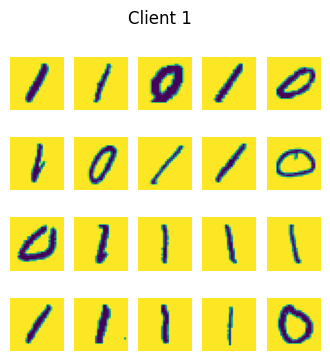

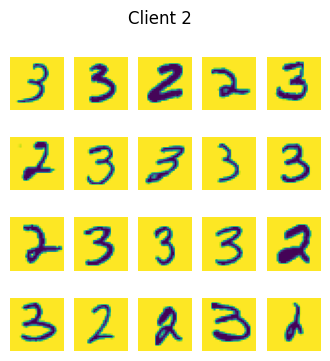

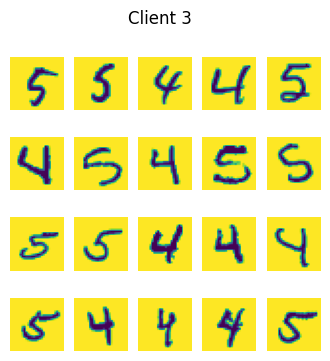

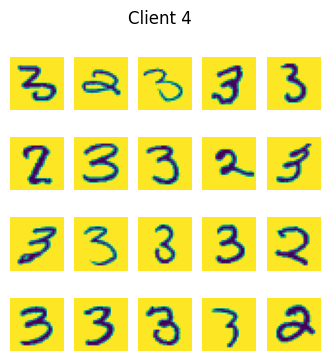

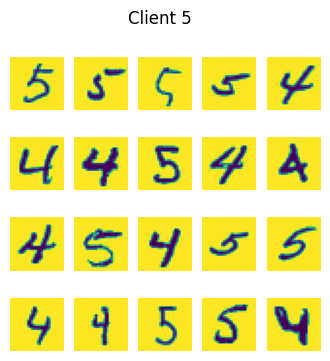

In [8]:
plot_samples(next(iter(mnist_non_iid_train_dls[0])), 0, "Client 1")
plot_samples(next(iter(mnist_non_iid_train_dls[1])), 0, "Client 2")
plot_samples(next(iter(mnist_non_iid_train_dls[2])), 0, "Client 3")
plot_samples(next(iter(mnist_non_iid_train_dls[1])), 0, "Client 4")
plot_samples(next(iter(mnist_non_iid_train_dls[2])), 0, "Client 5")

In [95]:


class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
init_model = CNN()


def classifier_loss(predictions,labels):
    
    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")
    
    return loss(m(predictions) ,labels.view(-1))


def dataset_loss(model, dataset, loss_f):
    loss=0
    
    for idx,(features,labels) in enumerate(dataset):
        
        predictions= model(features)
        loss+=loss_f(predictions,labels)
    
    loss/=idx+1
    
    return loss


def accuracy_dataset(model, dataset):   
    correct=0
    
    for features,labels in iter(dataset):
        
        predictions= model(features)
        
        _,predicted=predictions.max(1,keepdim=True)
        
        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()
        
    accuracy = 100*correct/len(dataset.dataset)
        
    return accuracy


def training(model, optimizer, train_data, loss_f):
    
    total_loss = 0
    
    for idx, (features,labels) in enumerate(train_data):
        
        optimizer.zero_grad()
        
        predictions = model(features)
        
        loss = loss_f(predictions,labels)
        total_loss+= loss
        
        loss.backward()
        optimizer.step()
        
    return total_loss/(idx+1)


In [96]:
def model_avg(model, clients_models_hist:list , weights:list):

    new_model = deepcopy(model)
    
    for layer_w in new_model.parameters():
        layer_w.data.sub_(layer_w.data)

    for k,client_hist in enumerate(clients_models_hist):
        
        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)
            
    return new_model

In [137]:
def FedAvg(model, training_sets:list, n_iter:int, testing_sets:list, epochs, lr, decay=1):

#     m = nn.LogSoftmax(dim=1)
#     loss = nn.NLLLoss(reduction="mean")
#     loss_f = loss(m(predictions) ,labels.view(-1))
    
    loss_f = classifier_loss
    
    num_clients = len(training_sets) 
    n_samples = sum([len(n.dataset) for n in training_sets]) #summing up number of samples in each training set
    weights = ([len(n.dataset)/n_samples for n in training_sets])
    #print(weights)
    
    
    loss_hist = [[float(dataset_loss(model, dl, loss_f).detach()) for dl in training_sets]]
    acc_hist = [[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist = [[tens_param.detach().numpy() for tens_param in list(model.parameters())]]
    models_hist = []
    
    server_loss_his = []
    weights_his = []
    
    server_loss = sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc = sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    server_loss_his.append(server_loss)
    
    for i in range(n_iter):
        
        client_params = []
        client_models = []
        client_losses = []
        
        for k in range(num_clients):
            
            local_model = deepcopy(model)
            local_optimizer = optim.SGD(local_model.parameters(),lr=lr)
            
            for e in range(epochs):
                local_loss = training(local_model,local_optimizer,training_sets[k],loss_f)
                local_loss = float(local_loss.detach().numpy())
                client_losses.append(local_loss)
                
            list_params = list(local_model.parameters())
            list_params = [tens_param.detach() for tens_param in list_params]
            client_params.append(list_params)    
            client_models.append(deepcopy(local_model))
        
        
        model = model_avg(deepcopy(model), client_params, weights=weights)
        weights_his.append(weights)
        models_hist.append(client_models)
        
    
        loss_hist += [[float(dataset_loss(model, dl, loss_f).detach()) for dl in training_sets]]
        acc_hist += [[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss = sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc = sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
        server_loss_his.append(server_loss)
        #print(server_loss, server_acc')
        

        server_hist.append([tens_param.detach().cpu().numpy() for tens_param in list(model.parameters())])
        
        lr*=decay
        #print(weights_his)
            
    return model, loss_hist, acc_hist, server_loss_his

In [118]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    plt.figure()
    
    plt.suptitle(title)

    plt.subplot(1,2,1)
    lines=plt.plot(loss_hist)
    plt.title("Loss")
    plt.legend(lines,["C1", "C2", "C3","C4","C5"])

    plt.subplot(1,2,2)
    lines=plt.plot(acc_hist )
    plt.title("Test Accuracy")
    plt.legend(lines, ["C1", "C2", "C3","C4", "C5"])

In [138]:
n_iter=5

model_f, loss_FA_niid, acc_FA_niid, global_loss = FedAvg(init_model, mnist_non_iid_train_dls, 
    n_iter, mnist_non_iid_test_dls, epochs=2, lr=0.1)

print(global_loss)

[[0.178, 0.222, 0.201, 0.197, 0.202]]
[[0.178, 0.222, 0.201, 0.197, 0.202], [0.178, 0.222, 0.201, 0.197, 0.202]]
[[0.178, 0.222, 0.201, 0.197, 0.202], [0.178, 0.222, 0.201, 0.197, 0.202], [0.178, 0.222, 0.201, 0.197, 0.202]]
[[0.178, 0.222, 0.201, 0.197, 0.202], [0.178, 0.222, 0.201, 0.197, 0.202], [0.178, 0.222, 0.201, 0.197, 0.202], [0.178, 0.222, 0.201, 0.197, 0.202]]
[[0.178, 0.222, 0.201, 0.197, 0.202], [0.178, 0.222, 0.201, 0.197, 0.202], [0.178, 0.222, 0.201, 0.197, 0.202], [0.178, 0.222, 0.201, 0.197, 0.202], [0.178, 0.222, 0.201, 0.197, 0.202]]
[2.300896683216095, 2.265797664642334, 2.221769561290741, 1.9705666496753693, 1.755427318096161, 1.508705226302147]


Text(0, 0.5, 'server loss')

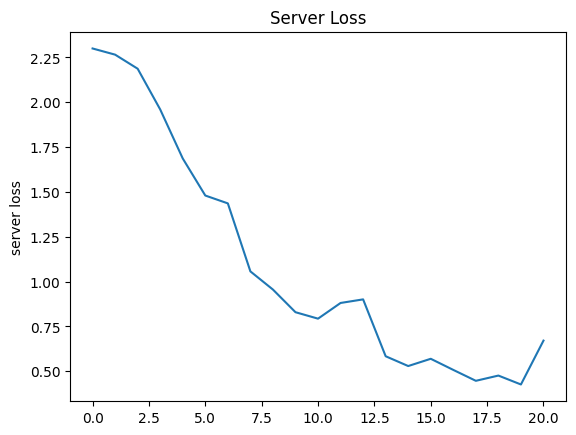

In [113]:
plt.plot(global_loss)
plt.title('Server Loss')
plt.ylabel('server loss')

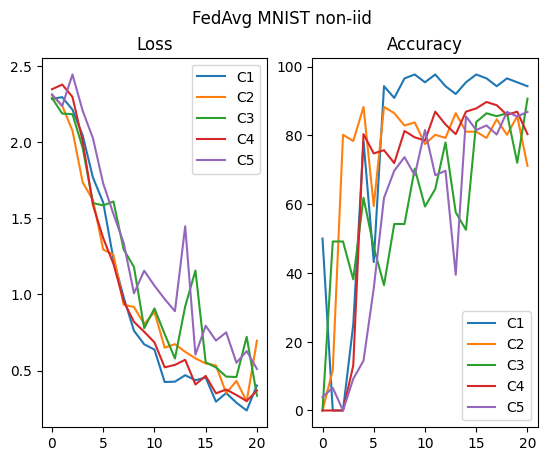

In [89]:
plot_acc_loss("FedAvg MNIST non-iid", loss_FA_niid, acc_FA_niid)

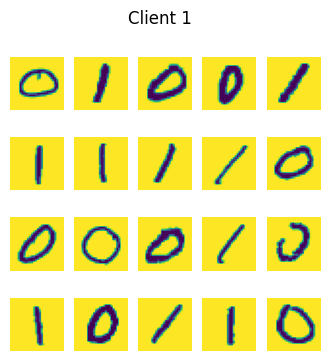

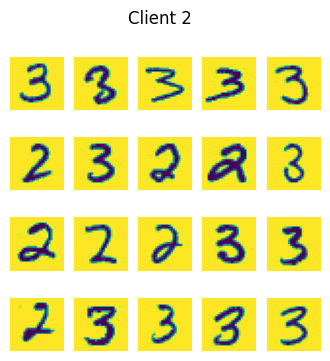

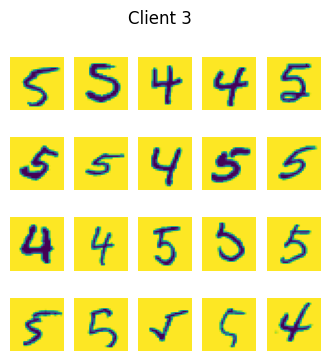

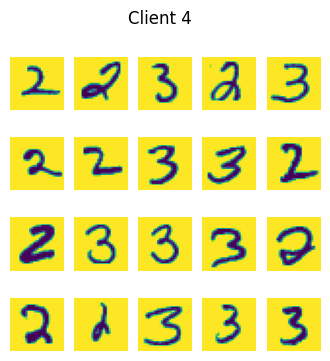

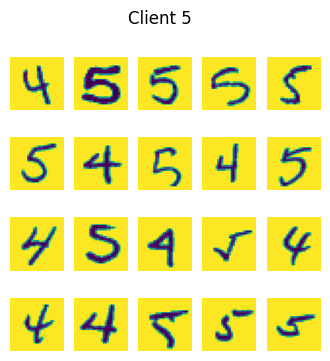

In [45]:
plot_samples(next(iter(mnist_non_iid_train_dls[0])), 0, "Client 1")
plot_samples(next(iter(mnist_non_iid_train_dls[1])), 0, "Client 2")
plot_samples(next(iter(mnist_non_iid_train_dls[2])), 0, "Client 3")
plot_samples(next(iter(mnist_non_iid_train_dls[1])), 0, "Client 4")
plot_samples(next(iter(mnist_non_iid_train_dls[2])), 0, "Client 5")

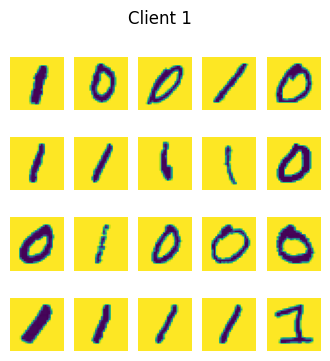

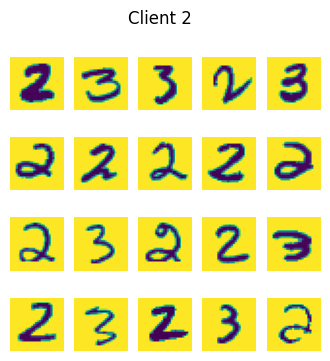

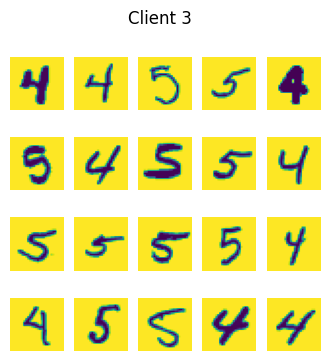

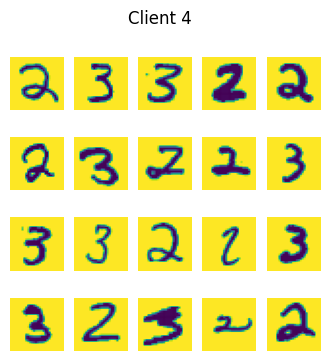

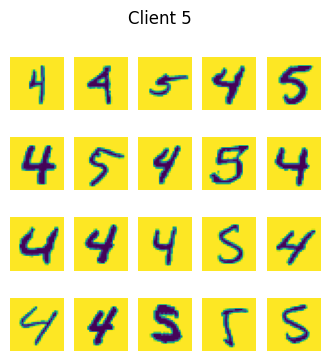

In [46]:
plot_samples(next(iter(mnist_non_iid_test_dls[0])), 0, "Client 1")
plot_samples(next(iter(mnist_non_iid_test_dls[1])), 0, "Client 2")
plot_samples(next(iter(mnist_non_iid_test_dls[2])), 0, "Client 3")
plot_samples(next(iter(mnist_non_iid_test_dls[1])), 0, "Client 4")
plot_samples(next(iter(mnist_non_iid_test_dls[2])), 0, "Client 5")